In [2]:
import os
# move 2 directories up
os.chdir(os.path.dirname(os.path.dirname(os.getcwd())))

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from joblib import dump
from scipy.stats import norm, multivariate_normal
import lightgbm as lgb
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import pickle as pkl
import joblib as joblib
target = 'net_target+1'

In [4]:
power = pd.read_csv('debug_logs/real_power_point_9000_1.csv')
power = power.melt(id_vars=['time_step'], var_name='building', value_name='net_target')
power = power.sort_values(by=['time_step', 'building'])
power['building'] = power['building'].str[-1].astype(int)
power = power[power['time_step'] != -1]
lead_times = ['net_target+'+str(i) for i in range(24)]
# upload min-max scaler from scalers folders with .save extension
scalers = [joblib.load(f'scalers/scaler_net_{k}.save') for k in range(1, 6)]
power_norm = pd.DataFrame()
for building in range(5):
    power_norm_temp = pd.DataFrame()
    power_norm_temp['time_step'] = power.loc[power['building'] == building, 'time_step']
    power_norm_temp['building'] = building
    power_norm_temp['net_target'] = power.loc[power['building'] == building, 'net_target']
    for i, lead_time in enumerate(lead_times):
        power_norm_temp[lead_time] = power_norm_temp['net_target'].shift(-int(i))
        # noramalize using the scaler 
        power_norm_temp[lead_time] = scalers[building].transform(power_norm_temp[lead_time].values.reshape(-1, 1))
    power_norm = pd.concat([power_norm, power_norm_temp], axis=0)
power_norm = power_norm.dropna()
power_norm = power_norm.sort_values(by=['time_step', 'building'])
# drop the net_target column
power_norm = power_norm.drop(columns=['net_target'])
# set the index to time_step and building
power_norm = power_norm.set_index(['time_step', 'building'])
power_norm

net_target+0  net_target+1  net_target+2  net_target+3  \
time_step building                                                           
0         0             0.383397      0.381964      0.382273      0.437649   
          1             0.483257      0.452162      0.387754      0.387709   
          2             0.409185      0.409185      0.409185      0.409185   
          3             0.631288      0.448667      0.446456      0.444920   
          4             0.445060      0.443450      0.447577      0.444650   
...                          ...           ...           ...           ...   
8735      0             0.446581      0.359917      0.361038      0.359627   
          1             0.589339      0.384510      0.411996      0.414704   
          2             0.499823      0.464959      0.463450      0.466443   
          3             0.830277      0.652891      0.711623      0.462304   
          4             0.548914      0.505189      0.499658      0.456720   

                    net_target+4  net_target+5  net_target+6  net_target+7  \
time_step building                                                           
0         0             0.418428      0.466455      0.341153      0.267408   
          1             0.499620      0.362711      0.389762      0.454266   
          2             0.409185      0.405686      0.391654      0.404757   
          3             0.447418      0.468951      0.476724      0.659505   
          4             0.418376      0.427833      0.414805      0.371538   
...                          ...           ...           ...           ...   
8735      0             0.360479      0.360861      0.376404      0.328893   
          1             0.543799      0.365497      0.361903      0.350758   
          2             0.458748      0.457579      0.449467      0.439400   
          3             0.480714      0.633036      0.447497      0.495956   
          4             0.454899      0.427567      0.436070      0.361513   

                    net_target+8  net_target+9  ...  net_target+14  \
time_step building                              ...                  
0         0             0.207303      0.153254  ...       0.258309   
          1             0.411655      0.471360  ...       0.433012   
          2             0.297595      0.271606  ...       0.227862   
          3             0.601217      0.446007  ...       0.140766   
          4             0.348402      0.358594  ...       0.366649   
...                          ...           ...  ...            ...   
8735      0             0.275541      0.224087  ...       0.292499   
          1             0.364814      0.488771  ...       0.434025   
          2             0.400822      0.325242  ...       0.227845   
          3             0.650026      0.441110  ...       0.413034   
          4             0.278724      0.204954  ...       0.445852   

                    net_target+15  net_target+16  net_target+17  \
time_step building                                                
0         0              0.283984       0.314944       0.401013   
          1              0.348603       0.258984       0.246717   
          2              0.185584       0.196730       0.296364   
          3              0.128045       0.381866       0.409008   
          4              0.363123       0.383307       0.670630   
...                           ...            ...            ...   
8735      0              0.319800       0.379287       0.537810   
          1              0.450167       0.173749       0.197350   
          2              0.327718       0.341778       0.445648   
          3              0.347415       0.416779       0.516825   
          4              0.527084       0.589056       0.771749   

                    net_target+18  net_target+19  net_target+20  \
time_step building                                                
0         0              0.396873       0.621485       0.742961   
      

In [5]:
preds = pd.read_csv('data/together_forecast/phase_1_forecast_sampled_1h.csv')
preds = preds.drop(columns=['scenario'])
pred_cols =  [f"+{{}}h".format(str(i)) for i in range(24)]
# name preds.columns[2:] columns as pred_cols
preds = preds.rename(columns={preds.columns[2:][i]: pred_cols[i] for i in range(24)})
# noramalize using the scaler 
for building in preds['building'].unique():
    for col in pred_cols:
        preds.loc[preds['building'] == building, col] = scalers[building].transform(preds.loc[preds['building'] == building, col].values.reshape(-1, 1))
# make an index from the time_step and building columns
preds = preds.set_index(['time_step', 'building'])
# keep only indexes that are in the power_norm dataframe
preds = preds[preds.index.isin(power_norm.index)]
preds

+0h       +1h       +2h       +3h       +4h  \
time_step building                                                     
0         0         0.423553  0.396045  0.386097  0.381390  0.380296   
          1         0.469386  0.439399  0.426474  0.420335  0.418915   
          2         0.452043  0.474018  0.480926  0.485107  0.490910   
          3         0.577648  0.522987  0.502625  0.494995  0.494086   
          4         0.475903  0.473434  0.467899  0.468364  0.470579   
...                      ...       ...       ...       ...       ...   
8735      0         0.422892  0.381904  0.381291  0.383043  0.385922   
          1         0.621736  0.552781  0.482267  0.435900  0.415848   
          2         0.504788  0.505042  0.495616  0.487739  0.480682   
          3         0.714991  0.647184  0.564205  0.540495  0.547929   
          4         0.520971  0.489226  0.474067  0.461804  0.453188   

                         +5h       +6h       +7h       +8h       +9h  ...  \
time_step building                                                    ...   
0         0         0.383587  0.371259  0.331875  0.297014  0.271443  ...   
          1         0.423323  0.406919  0.354432  0.307931  0.273791  ...   
          2         0.497148  0.486768  0.431755  0.382884  0.346996  ...   
          3         0.497005  0.471257  0.399775  0.333549  0.283644  ...   
          4         0.475237  0.459789  0.406709  0.358450  0.321666  ...   
...                      ...       ...       ...       ...       ...  ...   
8735      0         0.403011  0.407922  0.369696  0.303299  0.232935  ...   
          1         0.399265  0.385319  0.390911  0.369834  0.327757  ...   
          2         0.486762  0.491713  0.474553  0.437867  0.370747  ...   
          3         0.551642  0.518857  0.545747  0.542490  0.522735  ...   
          4         0.450742  0.429298  0.357704  0.271722  0.233621  ...   

                        +14h      +15h      +16h      +17h      +18h  \
time_step building                                                     
0         0         0.280734  0.348726  0.382043  0.418963  0.437243   
          1         0.285810  0.376974  0.421417  0.470672  0.495142   
          2         0.365413  0.466791  0.511635  0.564178  0.587676   
          3         0.295478  0.416465  0.473462  0.540088  0.574470   
          4         0.336300  0.435459  0.479766  0.535195  0.557345   
...                      ...       ...       ...       ...       ...   
8735      0         0.210259  0.245423  0.309214  0.428273  0.525800   
          1         0.305229  0.332858  0.321897  0.360692  0.402269   
          2         0.275491  0.325771  0.357150  0.435450  0.475901   
          3         0.399124  0.433789  0.439696  0.539021  0.631571   
          4         0.435279  0.492756  0.581578  0.676911  0.729542   

                        +19h      +20h      +21h      +22h      +23h  
time_step building                                                    
0         0         0.423429  0.427191  0.427694  0.431228  0.420512  
          1         0.476546  0.481574  0.482211  0.486827  0.472242  
          2         0.568407  0.571096  0.566701  0.557983  0.516115  
          3         0.555615  0.562027  0.561195  0.567942  0.554283  
          4         0.540159  0.542451  0.539419  0.531665  0.511427  
...                      ...       ...       ...       ...       ...  
8735      0         0.552262  0.568185  0.547756  0.515229  0.476495  
          1         0.489871  0.461384  0.474435  0.486944  0.549249  
          2         0.580239  0.569431  0.560324  0.553981  0.557410  
          3         0.701066  0.559558  0.590742  0.646746  0.674868  
          4         0.672202  0.521092  0.524071  0.573418  0.563907  

[43680 rows x 24 columns]

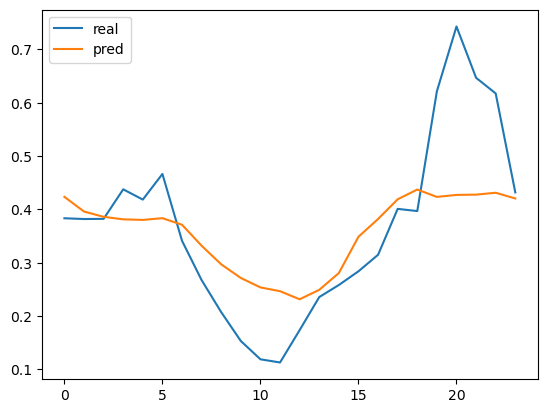

In [6]:
# plot the first row of power_norm
plt.plot(list(range(24)),power_norm.iloc[0, :].T, label='real')
# plot the first row of preds
plt.plot(list(range(24)),preds.iloc[0, :].T, label='pred')
plt.legend()
plt.show()

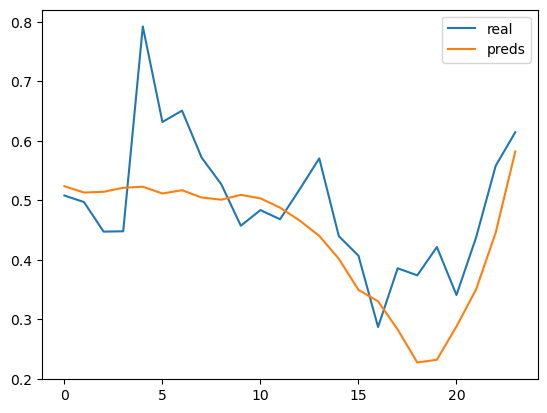

In [7]:
# do the same for the last row
plt.plot(list(range(24)),power_norm.iloc[5612, :].T, label='real')
plt.plot(list(range(24)),preds.iloc[5612, :].T, label='preds')
plt.legend()
plt.show()

In [8]:
# find residuals between power and preds
residuals = power_norm.copy()
for i in range(24):
    col_preds = '+{}h'.format(i)
    col_power = 'net_target+{}'.format(i)
    col_residuals = 'residuals+{}'.format(i)
    residuals[col_residuals] = residuals[col_power] - preds[col_preds]
# drop the power columns
residuals = residuals.drop(columns=[col for col in residuals.columns if 'net_target' in col])
residuals['Hour'] = (residuals.index.get_level_values(0)) % 24
# move hour column to the first position
cols = residuals.columns.tolist()
cols = cols[-1:] + cols[:-1]
residuals = residuals[cols]
residuals

Hour  residuals+0  residuals+1  residuals+2  residuals+3  \
time_step building                                                             
0         0            0    -0.040156    -0.014081    -0.003824     0.056258   
          1            0     0.013872     0.012763    -0.038721    -0.032626   
          2            0    -0.042857    -0.064833    -0.071741    -0.075922   
          3            0     0.053641    -0.074320    -0.056169    -0.050075   
          4            0    -0.030843    -0.029985    -0.020322    -0.023714   
...                  ...          ...          ...          ...          ...   
8735      0           23     0.023689    -0.021988    -0.020253    -0.023416   
          1           23    -0.032397    -0.168271    -0.070271    -0.021196   
          2           23    -0.004966    -0.040083    -0.032166    -0.021296   
          3           23     0.115287     0.005707     0.147418    -0.078191   
          4           23     0.027943     0.015963     0.025591    -0.005084   

                    residuals+4  residuals+5  residuals+6  residuals+7  \
time_step building                                                       
0         0            0.038132     0.082869    -0.030106    -0.064467   
          1            0.080705    -0.060612    -0.017157     0.099834   
          2           -0.081725    -0.091462    -0.095114    -0.026998   
          3           -0.046668    -0.028054     0.005467     0.259730   
          4           -0.052203    -0.047405    -0.044984    -0.035170   
...                         ...          ...          ...          ...   
8735      0           -0.025443    -0.042150    -0.031517    -0.040803   
          1            0.127950    -0.033769    -0.023415    -0.040153   
          2           -0.021934    -0.029183    -0.042246    -0.035153   
          3           -0.067215     0.081394    -0.071360    -0.049791   
          4            0.001711    -0.023175     0.006772     0.003809   

                    residuals+8  ...  residuals+14  residuals+15  \
time_step building               ...                               
0         0           -0.089711  ...     -0.022425     -0.064742   
          1            0.103724  ...      0.147201     -0.028371   
          2           -0.085289  ...     -0.137551     -0.281208   
          3            0.267668  ...     -0.154712     -0.288420   
          4           -0.010048  ...      0.030350     -0.072336   
...                         ...  ...           ...           ...   
8735      0           -0.027758  ...      0.082239      0.074378   
          1           -0.005020  ...      0.128796      0.117309   
          2           -0.037046  ...     -0.047646      0.001946   
          3            0.107536  ...      0.013909     -0.086374   
          4            0.007002  ...      0.010573      0.034328   

                    residuals+16  residuals+17  residuals+18  residuals+19  \
time_step building                                                           
0         0            -0.067100     -0.017950     -0.040370      0.198056   
          1            -0.162433     -0.223955     -0.178099     -0.110132   
          2            -0.314905     -0.267814     -0.184338     -0.159222   
          3            -0.091596     -0.131080     -0.166782      0.029119   
          4            -0.096459      0.135435      0.068565      0.028238   
...                          ...           ...           ...           ...   
8735      0             0.070074      0.109537     -0.038698     -0.128760   
          1            -0.148148     -0.163342     -0.122284      0.008624   
          2            -0.015373      0.010198      0.026844      0.010764   
          3            -0.022917     -0.022195     -0.083364     -0.112052   
          4             0.007478      0.094838      0.132580      0.048643   

                    residuals+20  residuals+21  residuals+22  residuals+23  
time_step building                     

In [32]:
# find a correlation matrix between lead times
corr = residuals.iloc[:, 1:].corr()
# for each hour, find the correlation between the lead times
corr_hour = {}
stds = {}
means = {}
for hour in range(0, 24):
    corr_hour[hour] = residuals.loc[residuals['Hour'] == hour].iloc[:, 1:].corr()
    stds[hour] = residuals.loc[residuals['Hour'] == hour].iloc[:, 1:].std()
    means[hour] = residuals.loc[residuals['Hour'] == hour].iloc[:, 1:].mean()
# save the correlation matrix and the standard deviations to pickle files
# with open('models/residuals_corr/corr.pkl', 'wb') as f:
#     pkl.dump(corr, f)
# with open('models/residuals_corr/corr_hour.pkl', 'wb') as f:
#     pkl.dump(corr_hour, f)

In [33]:
# convert the correlation matrix for each hour to a covariance matrix
cov_hour = {}
mvn_hour = {}
for hour in range(0, 24):
    cov_hour[hour] = np.outer(stds[hour], stds[hour]) * corr_hour[hour]
    mvn_hour[hour] = multivariate_normal(mean=[0]*24, cov=cov_hour[hour])
# save the covariance matrix to a pickle file
# with open('models/residuals_corr/cov_hour.pkl', 'wb') as f:
#     pkl.dump(cov_hour, f)
# save the multivariate normal distributions to pickle files
# with open('models/residuals_corr/mvn_hour.pkl', 'wb') as f:
#     pkl.dump(mvn_hour, f)

<AxesSubplot:>

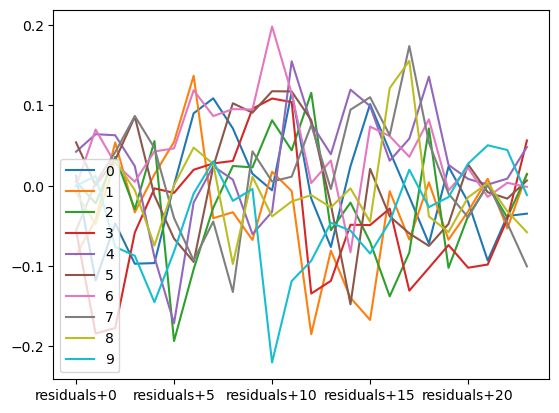

In [36]:
rv_mvnorm = multivariate_normal([0]*24, cov_hour[6])
simulation_mvnorm = rv_mvnorm.rvs(10)
simulation_uniform = pd.DataFrame(data=simulation_mvnorm, 
                                              columns = corr.columns)
simulation_uniform.T.plot()

In [39]:
# find mean residual for each hour
mean_residuals = residuals.groupby('Hour').std()
mean_residuals

,residuals+0,residuals+1,residuals+2,residuals+3,residuals+4,residuals+5,residuals+6,residuals+7,residuals+8,residuals+9,...,residuals+14,residuals+15,residuals+16,residuals+17,residuals+18,residuals+19,residuals+20,residuals+21,residuals+22,residuals+23
Hour,,,,,,,,,,,,,,,,,,,,,
0,0.056548,0.054062,0.047556,0.048317,0.044540,0.048972,0.051444,0.055162,0.067049,0.071794,...,0.079369,0.084262,0.089770,0.084347,0.088376,0.077549,0.077731,0.080976,0.076317,0.072517
1,0.049805,0.045794,0.047143,0.044073,0.048616,0.051253,0.054633,0.066769,0.071382,0.077061,...,0.083999,0.089618,0.084368,0.088531,0.077506,0.077919,0.080902,0.076012,0.072303,0.064590
2,0.041061,0.045112,0.043022,0.048005,0.050937,0.054385,0.066400,0.071107,0.076834,0.079651,...,0.089876,0.084393,0.088104,0.077537,0.077748,0.080914,0.076066,0.072131,0.064299,0.057812
3,0.042694,0.041824,0.047339,0.050291,0.054064,0.066351,0.071209,0.076740,0.079826,0.080625,...,0.084591,0.088268,0.077631,0.077754,0.080703,0.076146,0.072186,0.064212,0.057858,0.050360
4,0.040726,0.046160,0.049771,0.053798,0.066391,0.070873,0.076875,0.079829,0.080990,0.082068,...,0.088296,0.077769,0.077756,0.080814,0.076103,0.072283,0.064069,0.057810,0.049935,0.050917
5,0.044020,0.049613,0.053513,0.066017,0.070942,0.076707,0.079876,0.081052,0.082320,0.079081,...,0.077550,0.077730,0.080863,0.076179,0.072261,0.064290,0.057802,0.049932,0.050445,0.046248
6,0.049390,0.053169,0.065984,0.070930,0.076546,0.079938,0.081167,0.082344,0.079435,0.083827,...,0.077512,0.080817,0.076125,0.072310,0.064195,0.057851,0.049949,0.050305,0.045973,0.049930
7,0.050978,0.064948,0.070975,0.076587,0.079822,0.081066,0.082382,0.079179,0.084079,0.089932,...,0.080797,0.076094,0.071969,0.064161,0.057843,0.049895,0.050364,0.045966,0.050163,0.052719
8,0.058612,0.069001,0.076163,0.079526,0.080489,0.081978,0.078946,0.083983,0.090244,0.084303,...,0.076052,0.071957,0.063837,0.057733,0.049964,0.050313,0.046042,0.050228,0.052921,0.056162


<AxesSubplot:>

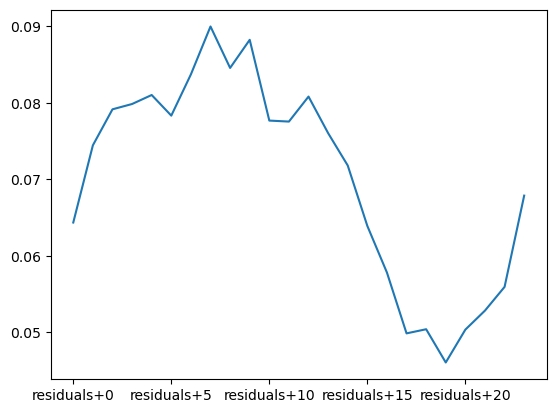

In [40]:
mean_residuals.T[9].plot()

In [42]:
# save the mean residuals to a dict and then to a pickle file
mean_residuals_dict = {}
for hour in range(0, 24):
    mean_residuals_dict[hour] = mean_residuals.iloc[hour, :].values
with open('models/residuals_norm/std_residuals_norm.pkl', 'wb') as f:
    pkl.dump(mean_residuals_dict, f)